In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from scipy import stats

In [2]:
pd.options.display.float_format = "{:,.7f}".format

In [3]:
RANDOM_SEED = 12
np.random.seed(RANDOM_SEED)

# Mean Poisson values
theta_noalcohol_meds = 1  # no alcohol, took an antihist
theta_alcohol_meds = 3  # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36  # alcohol, no antihist

# Gamma shape parameter
alpha = 10


def get_nb_vals(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)


# Create samples
n = 1000
df = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            (
                get_nb_vals(theta_noalcohol_meds, alpha, n),
                get_nb_vals(theta_alcohol_meds, alpha, n),
                get_nb_vals(theta_noalcohol_nomeds, alpha, n),
                get_nb_vals(theta_alcohol_nomeds, alpha, n),
            )
        ),
        "alcohol": np.concatenate(
            (
                np.repeat(False, n),
                np.repeat(True, n),
                np.repeat(False, n),
                np.repeat(True, n),
            )
        ),
        "nomeds": np.concatenate(
            (
                np.repeat(False, n),
                np.repeat(False, n),
                np.repeat(True, n),
                np.repeat(True, n),
            )
        ),
    }
)
df

,nsneeze,alcohol,nomeds
0,2,False,False
1,1,False,False
2,3,False,False
3,0,False,False
4,0,False,False
...,...,...,...
3995,28,True,True
3996,23,True,True
3997,44,True,True
3998,20,True,True


In [4]:
df.groupby(["nomeds", "alcohol"])["nsneeze"].agg(["mean", "var"])

mean         var
nomeds alcohol                       
False  False    0.9600000   1.0174174
       True     3.0210000   3.9825415
True   False    5.9500000   9.0945946
       True    35.4610000 160.8433223

In [5]:
M = torch.tensor(df.nomeds.to_numpy(), dtype=torch.float64, requires_grad=False)
A = torch.tensor(df.alcohol.to_numpy(), dtype=torch.float64, requires_grad=False)
S = torch.tensor(df.nsneeze.to_numpy(), dtype=torch.float64, requires_grad=False)

In [6]:
df

,nsneeze,alcohol,nomeds
0,2,False,False
1,1,False,False
2,3,False,False
3,0,False,False
4,0,False,False
...,...,...,...
3995,28,True,True
3996,23,True,True
3997,44,True,True
3998,20,True,True


In [7]:
import pyro.distributions.constraints as constraints

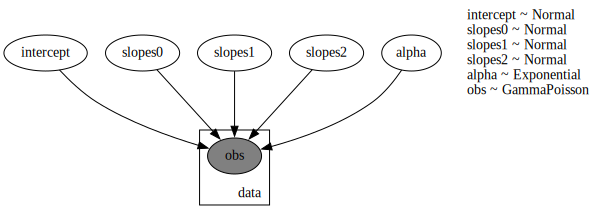

In [8]:
def model(M, A, S=None):
    a = pyro.sample("intercept", dist.Normal(0, 5.0))
    b0 = pyro.sample("slopes0", dist.Normal(0, 1.0))
    b1 = pyro.sample("slopes1", dist.Normal(0, 1.0))
    b2 = pyro.sample("slopes2", dist.Normal(0, 1.0))
    # a = pyro.sample("intercept", dist.HalfNormal(5.0))
    # b0 = pyro.sample("slopes0", dist.HalfNormal(1.0))
    # b1 = pyro.sample("slopes1", dist.HalfNormal(1.0))
    # b2 = pyro.sample("slopes2", dist.HalfNormal(1.0))
    alpha = pyro.sample("alpha", dist.Exponential(0.5))

    rate = torch.exp(a + b0 * M + b1 * A + b2 * M * A)

    with pyro.plate("data", len(M)):
        return pyro.sample("obs", dist.GammaPoisson(alpha, rate), obs=S)


pyro.render_model(
    model, model_args=(M, A, S), render_distributions=True, render_params=True
)

Elbo loss: 8.884061908292798
Elbo loss: 2.5973587667402493
Elbo loss: 2.4743917400900566
Elbo loss: 2.4481630541610753
Elbo loss: 2.440955939318851
Elbo loss: 2.441249486925874
Elbo loss: 2.440297399768336
Elbo loss: 2.4406592160751597
Elbo loss: 2.44158035805617
Elbo loss: 2.4452946831563502
Elbo loss: 2.440714314326436
Elbo loss: 2.440498825046968
Elbo loss: 2.4408295841518948
Elbo loss: 2.4404048273172925
Elbo loss: 2.4395724070870246
Elbo loss: 2.4409585346510108
Elbo loss: 2.441999001595469
Elbo loss: 2.442502906036817
Elbo loss: 2.441242723057996
Elbo loss: 2.4473029999090796


Text(0, 0.5, 'ELBO loss')

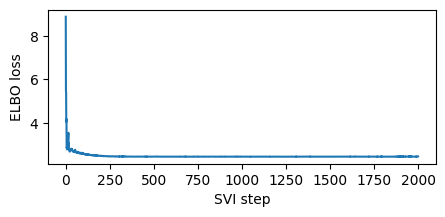

In [9]:
pyro.clear_param_store()

# These should be reset each training loop.

# auto_guide = pyro.infer.autoguide.AutoNormal(model)
auto_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

adam = pyro.optim.Adam({"lr": 0.1})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(2_000):  # Consider running for more steps.
    loss = svi.step(M, A, S)
    losses.append(loss / len(S))
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss / len(S)))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

In [10]:
auto_guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoMultivariateNormal.loc Parameter containing:
tensor([ 2.3326, -1.8180, -1.1448, -0.6496,  2.3042])
AutoMultivariateNormal.scale tensor([0.0254, 0.0167, 0.0205, 0.0186, 0.0083])
AutoMultivariateNormal.scale_tril tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.6814,  1.0000,  0.0000,  0.0000,  0.0000],
        [-0.6265,  0.2704,  1.0000,  0.0000,  0.0000],
        [ 0.5747, -0.9215, -0.9965,  1.0000,  0.0000],
        [ 1.3502,  1.3338,  0.6470,  0.1247,  1.0000]])


In [11]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1_000)
svi_samples = predictive(M, A, S=None)

In [12]:
svi_samples.keys()

dict_keys(['intercept', 'slopes0', 'slopes1', 'slopes2', 'alpha', 'obs'])

In [13]:
svi_samples["obs"].shape

torch.Size([1000, 4000])

In [14]:
svi_samples["obs"].numpy()

array([[ 3.,  1.,  0., ..., 32., 25., 38.],
       [ 0.,  0.,  1., ..., 42., 52., 41.],
       [ 1.,  0.,  0., ..., 28., 18., 29.],
       ...,
       [ 1.,  0.,  1., ..., 23., 18., 38.],
       [ 2.,  0.,  0., ..., 22., 42., 32.],
       [ 0.,  0.,  2., ..., 28., 31., 30.]])

In [15]:
y_pred = np.percentile(svi_samples["obs"].numpy(), q=50, axis=0)

In [16]:
pd.DataFrame(
    {
        k: svi_samples[k].numpy().reshape(-1)
        for k in svi_samples
        if "intercept" in k or "slope" in k or "alpha" in k
    }
).describe(percentiles=[0.03, 0.5, 0.97])

,intercept,slopes0,slopes1,slopes2,alpha
count,"1,000.0000000","1,000.0000000","1,000.0000000","1,000.0000000","1,000.0000000"
mean,2.3330827,-1.8181473,-1.1453149,-0.6498303,10.0192814
std,0.0240991,0.0203172,0.0240663,0.0336915,0.1796786
min,2.2478218,-1.8836892,-1.2237928,-0.7421631,9.4035130
3%,2.2851561,-1.8548828,-1.1920817,-0.7157222,9.6800721
50%,2.3333527,-1.8179882,-1.1458105,-0.6490692,10.0152698
97%,2.3773839,-1.7787192,-1.1026066,-0.5872247,10.3488892
max,2.4073946,-1.7606465,-1.0592051,-0.5505782,10.5254488


In [17]:
df.describe(percentiles=[0.03, 0.25, 0.5, 0.75, 0.97])

,nsneeze
count,"4,000.0000000"
mean,11.3480000
std,15.5147373
min,0.0000000
3%,0.0000000
25%,1.0000000
50%,4.0000000
75%,13.0000000
97%,50.0000000
max,94.0000000


In [18]:
pd.DataFrame(
    {"y_pred": svi_samples[k].numpy().reshape(-1) for k in svi_samples if "obs" in k} # haha i'm lazy xD
).describe(percentiles=[0.03, 0.25, 0.5, 0.75, 0.97])

,y_pred
count,"4,000,000.0000000"
mean,11.5144410
std,15.7837247
min,0.0000000
3%,0.0000000
25%,1.0000000
50%,4.0000000
75%,14.0000000
97%,51.0000000
max,127.0000000


In [19]:
y_true = df.nsneeze.values.reshape(-1)
np.abs(y_true - y_pred).mean()

3.66575